<a href="https://colab.research.google.com/github/Yorichiiii22/Agentic-AI/blob/main/content/02-getting-started/jupyter_notebooks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Jupyter Notebooks

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from enum import Enum
from dataclasses import dataclass
from typing import Tuple, List, Dict
import random
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Set style for professional visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Libraries imported successfully!")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

Libraries imported successfully!
NumPy version: 2.0.2
Pandas version: 2.2.2


In [3]:
class Moisture(Enum):
    """Soil moisture levels"""
    DRY = "DRY"           # < 30%
    MODERATE = "MODERATE" # 30-70%
    WET = "WET"           # > 70%

class Temperature(Enum):
    """Temperature ranges"""
    COLD = "COLD"  # < 15°C
    MILD = "MILD"  # 15-30°C
    HOT = "HOT"    # > 30°C

class Weather(Enum):
    """Weather conditions"""
    RAINY = "RAINY"
    CLOUDY = "CLOUDY"
    SUNNY = "SUNNY"

class Action(Enum):
    """Sprinkler actions"""
    OFF = "OFF"
    LOW = "LOW"
    HIGH = "HIGH"

print("State space enumerations defined successfully!")
print(f"\nTotal state space size: {len(Moisture)} × {len(Temperature)} × {len(Weather)} = {len(Moisture) * len(Temperature) * len(Weather)} states")
print(f"Action space size: {len(Action)} actions")

State space enumerations defined successfully!

Total state space size: 3 × 3 × 3 = 27 states
Action space size: 3 actions


In [4]:
@dataclass
class State:
    """Agent's internal state representation"""
    moisture: Moisture
    temperature: Temperature
    weather: Weather

    def __str__(self):
        return f"({self.moisture.value}, {self.temperature.value}, {self.weather.value})"

    def __hash__(self):
        return hash((self.moisture, self.temperature, self.weather))

@dataclass
class Percept:
    """Sensor readings at time t"""
    moisture_raw: float      # Raw moisture percentage 0-100
    temperature_raw: float   # Raw temperature in °C
    is_raining: bool        # Rain detection
    light_intensity: float  # Light intensity 0-100

    def classify(self) -> State:
        """Convert raw percept to discrete state"""
        # Classify moisture
        if self.moisture_raw < 30:
            m = Moisture.DRY
        elif self.moisture_raw <= 70:
            m = Moisture.MODERATE
        else:
            m = Moisture.WET

        # Classify temperature
        if self.temperature_raw < 15:
            t = Temperature.COLD
        elif self.temperature_raw <= 30:
            t = Temperature.MILD
        else:
            t = Temperature.HOT

        # Classify weather
        if self.is_raining:
            w = Weather.RAINY
        elif self.light_intensity < 40:
            w = Weather.CLOUDY
        else:
            w = Weather.SUNNY

        return State(m, t, w)

print("State and Percept classes defined!")

# Test classification
test_percept = Percept(moisture_raw=25, temperature_raw=32, is_raining=False, light_intensity=80)
test_state = test_percept.classify()
print(f"\nExample: Raw values (25% moisture, 32°C, sunny) → State {test_state}")

State and Percept classes defined!

Example: Raw values (25% moisture, 32°C, sunny) → State (DRY, HOT, SUNNY)


In [5]:
class Environment:
    """Simulates the physical environment for irrigation"""

    def __init__(self, initial_moisture=50, initial_temp=20):
        self.moisture = initial_moisture  # Current moisture percentage
        self.temperature = initial_temp   # Current temperature in °C
        self.is_raining = False
        self.light_intensity = 50
        self.time_step = 0

    def get_percept(self, add_noise=True) -> Percept:
        """Get current sensor readings with optional noise"""
        if add_noise:
            moisture_noise = np.random.normal(0, 2)  # ±2% noise
            temp_noise = np.random.normal(0, 0.5)    # ±0.5°C noise
        else:
            moisture_noise = 0
            temp_noise = 0

        return Percept(
            moisture_raw=np.clip(self.moisture + moisture_noise, 0, 100),
            temperature_raw=self.temperature + temp_noise,
            is_raining=self.is_raining,
            light_intensity=self.light_intensity
        )

    def update(self, action: Action, time_delta=1.0):
        """Update environment based on action and natural processes"""
        self.time_step += 1

        # Natural evaporation based on temperature and weather
        evaporation_rate = self._calculate_evaporation()
        self.moisture -= evaporation_rate * time_delta

        # Apply irrigation action
        if action == Action.LOW:
            self.moisture += 15 * time_delta  # Low pressure adds 15% per hour
        elif action == Action.HIGH:
            self.moisture += 30 * time_delta  # High pressure adds 30% per hour

        # Rain adds water
        if self.is_raining:
            self.moisture += 20 * time_delta

        # Clamp moisture to valid range
        self.moisture = np.clip(self.moisture, 0, 100)

        # Update weather and temperature (simplified diurnal cycle)
        self._update_weather()
        self._update_temperature()

    def _calculate_evaporation(self) -> float:
        """Calculate evaporation rate based on conditions"""
        base_rate = 2.0  # Base evaporation per hour

        # Temperature factor
        if self.temperature < 15:
            temp_factor = 0.5
        elif self.temperature <= 30:
            temp_factor = 1.0
        else:
            temp_factor = 2.0

        # Weather factor
        if self.is_raining:
            weather_factor = 0.1
        elif self.light_intensity < 40:
            weather_factor = 0.5
        else:
            weather_factor = 1.5

        return base_rate * temp_factor * weather_factor

    def _update_weather(self):
        """Stochastic weather transitions"""
        # Simple Markov chain for weather
        if self.is_raining:
            # Rain → Cloudy (60%), Rain (30%), Sunny (10%)
            rand = random.random()
            if rand < 0.3:
                self.is_raining = True
                self.light_intensity = 20
            elif rand < 0.9:
                self.is_raining = False
                self.light_intensity = 30
            else:
                self.is_raining = False
                self.light_intensity = 80
        else:
            # Not raining
            rand = random.random()
            if self.light_intensity < 40:  # Cloudy
                if rand < 0.2:
                    self.is_raining = True
                    self.light_intensity = 20
                elif rand < 0.7:
                    self.light_intensity = 35
                else:
                    self.light_intensity = 75
            else:  # Sunny
                if rand < 0.05:
                    self.is_raining = True
                    self.light_intensity = 20
                elif rand < 0.15:
                    self.light_intensity = 35
                else:
                    self.light_intensity = 80

    def _update_temperature(self):
        """Simulate diurnal temperature variation"""
        # Simple sinusoidal pattern + random walk
        hour_of_day = (self.time_step % 24)
        daily_variation = 10 * np.sin((hour_of_day - 6) * np.pi / 12)
        random_walk = np.random.normal(0, 1)

        target_temp = 20 + daily_variation + random_walk
        # Smooth transition
        self.temperature = 0.7 * self.temperature + 0.3 * target_temp

print("Environment class created!")

# Test environment
env = Environment()
print(f"\nInitial state: Moisture={env.moisture:.1f}%, Temperature={env.temperature:.1f}°C")
percept = env.get_percept(add_noise=False)
state = percept.classify()
print(f"Classified state: {state}")

Environment class created!

Initial state: Moisture=50.0%, Temperature=20.0°C
Classified state: (MODERATE, MILD, SUNNY)


In [6]:
class WaterSprinklerAgent:
    """Rational agent for sprinkler control"""

    def __init__(self):
        self.state = None
        self.history = []
        self.policy_table = self._build_policy_table()

    def sense(self, environment: Environment) -> Percept:
        """Read sensors from environment"""
        return environment.get_percept(add_noise=True)

    def update_state(self, percept: Percept):
        """Update internal state from percept"""
        self.state = percept.classify()

    def decide(self) -> Action:
        """Apply policy function π(s) → a"""
        return self.policy_table[self.state]

    def decide_with_rules(self) -> Action:
        """Rule-based decision making (explicit logic)"""
        m = self.state.moisture
        t = self.state.temperature
        w = self.state.weather

        # Priority 1: Safety rules
        if m == Moisture.WET:
            return Action.OFF  # Never irrigate when wet

        if w == Weather.RAINY:
            return Action.OFF  # Never irrigate during rain

        # Priority 2: Critical irrigation needs
        if m == Moisture.DRY and t == Temperature.HOT and w == Weather.SUNNY:
            return Action.HIGH  # Critical conditions require high pressure

        # Priority 3: Moderate irrigation needs
        if m == Moisture.DRY:
            return Action.LOW  # Dry soil needs water (low pressure sufficient)

        # Priority 4: Preventive irrigation
        if m == Moisture.MODERATE and t == Temperature.HOT and w == Weather.SUNNY:
            return Action.LOW  # Prevent drying in hot sunny conditions

        # Default: conserve water
        return Action.OFF

    def _build_policy_table(self) -> Dict[State, Action]:
        """Build complete policy table for all 27 states"""
        policy = {}

        for m in Moisture:
            for t in Temperature:
                for w in Weather:
                    state = State(m, t, w)

                    # Apply decision rules
                    if m == Moisture.WET or w == Weather.RAINY:
                        action = Action.OFF
                    elif m == Moisture.DRY and t == Temperature.HOT and w == Weather.SUNNY:
                        action = Action.HIGH
                    elif m == Moisture.DRY:
                        action = Action.LOW
                    elif m == Moisture.MODERATE and t == Temperature.HOT and w == Weather.SUNNY:
                        action = Action.LOW
                    else:
                        action = Action.OFF

                    policy[state] = action

        return policy

    def act(self, action: Action, environment: Environment):
        """Execute action in environment"""
        environment.update(action)
        self.history.append({
            'time': environment.time_step,
            'state': str(self.state),
            'action': action.value,
            'moisture': environment.moisture,
            'temperature': environment.temperature,
            'weather': 'RAINY' if environment.is_raining else ('CLOUDY' if environment.light_intensity < 40 else 'SUNNY')
        })

    def run_cycle(self, environment: Environment) -> Action:
        """Complete sense-think-act cycle"""
        percept = self.sense(environment)
        self.update_state(percept)
        action = self.decide()
        self.act(action, environment)
        return action

    def get_policy_summary(self) -> pd.DataFrame:
        """Get policy table as DataFrame"""
        data = []
        for state, action in self.policy_table.items():
            data.append({
                'Moisture': state.moisture.value,
                'Temperature': state.temperature.value,
                'Weather': state.weather.value,
                'Action': action.value
            })
        return pd.DataFrame(data)

print("WaterSprinklerAgent class created!")

# Test agent
agent = WaterSprinklerAgent()
print(f"\nPolicy table size: {len(agent.policy_table)} state-action mappings")
print("\nFirst 5 policy entries:")
print(agent.get_policy_summary().head())

WaterSprinklerAgent class created!

Policy table size: 27 state-action mappings

First 5 policy entries:
  Moisture Temperature Weather Action
0      DRY        COLD   RAINY    OFF
1      DRY        COLD  CLOUDY    LOW
2      DRY        COLD   SUNNY    LOW
3      DRY        MILD   RAINY    OFF
4      DRY        MILD  CLOUDY    LOW


In [7]:
agent = WaterSprinklerAgent()
policy_df = agent.get_policy_summary()

print("="*60)
print("COMPLETE POLICY TABLE (All 27 States)")
print("="*60)
print(policy_df.to_string(index=False))

# Action distribution
print("\n" + "="*60)
print("ACTION DISTRIBUTION")
print("="*60)
action_counts = policy_df['Action'].value_counts()
for action, count in action_counts.items():
    percentage = (count / 27) * 100
    print(f"{action:8s}: {count:2d} states ({percentage:5.1f}%)")

COMPLETE POLICY TABLE (All 27 States)
Moisture Temperature Weather Action
     DRY        COLD   RAINY    OFF
     DRY        COLD  CLOUDY    LOW
     DRY        COLD   SUNNY    LOW
     DRY        MILD   RAINY    OFF
     DRY        MILD  CLOUDY    LOW
     DRY        MILD   SUNNY    LOW
     DRY         HOT   RAINY    OFF
     DRY         HOT  CLOUDY    LOW
     DRY         HOT   SUNNY   HIGH
MODERATE        COLD   RAINY    OFF
MODERATE        COLD  CLOUDY    OFF
MODERATE        COLD   SUNNY    OFF
MODERATE        MILD   RAINY    OFF
MODERATE        MILD  CLOUDY    OFF
MODERATE        MILD   SUNNY    OFF
MODERATE         HOT   RAINY    OFF
MODERATE         HOT  CLOUDY    OFF
MODERATE         HOT   SUNNY    LOW
     WET        COLD   RAINY    OFF
     WET        COLD  CLOUDY    OFF
     WET        COLD   SUNNY    OFF
     WET        MILD   RAINY    OFF
     WET        MILD  CLOUDY    OFF
     WET        MILD   SUNNY    OFF
     WET         HOT   RAINY    OFF
     WET         HOT  CLOU

In [8]:
# Initialize scenario
env1 = Environment(initial_moisture=25, initial_temp=35)
env1.is_raining = False
env1.light_intensity = 90
agent1 = WaterSprinklerAgent()

# Run simulation for 48 hours
print("Starting simulation: Dry Hot Summer Day")
print("="*80)
print(f"{'Hour':>4} {'Moisture':>10} {'Temp':>8} {'Weather':>10} {'State':>25} {'Action':>8}")
print("="*80)

for hour in range(48):
    action = agent1.run_cycle(env1)

    if hour % 4 == 0:  # Print every 4 hours
        print(f"{hour:4d} {env1.moisture:9.1f}% {env1.temperature:7.1f}°C {agent1.history[-1]['weather']:>10} {str(agent1.state):>25} {action.value:>8}")

print("="*80)
print(f"Simulation complete. Final moisture: {env1.moisture:.1f}%")

Starting simulation: Dry Hot Summer Day
Hour   Moisture     Temp    Weather                     State   Action
   0      49.0%    27.6°C      RAINY         (DRY, HOT, SUNNY)     HIGH
   4      65.8%    17.6°C      RAINY  (MODERATE, MILD, CLOUDY)      OFF
   8      82.6%    22.7°C      SUNNY       (WET, MILD, CLOUDY)      OFF
  12      76.6%    27.2°C     CLOUDY       (WET, MILD, CLOUDY)      OFF
  16      66.6%    25.2°C      SUNNY   (MODERATE, MILD, SUNNY)      OFF
  20      54.6%    17.7°C      SUNNY   (MODERATE, MILD, SUNNY)      OFF
  24      90.4%    12.2°C     CLOUDY        (WET, COLD, RAINY)      OFF
  28      98.0%    15.0°C      SUNNY        (WET, COLD, SUNNY)      OFF
  32      87.5%    22.0°C      SUNNY        (WET, MILD, SUNNY)      OFF
  36     100.0%    28.1°C     CLOUDY        (WET, MILD, RAINY)      OFF
  40      99.0%    25.5°C     CLOUDY       (WET, MILD, CLOUDY)      OFF
  44      91.0%    17.0°C      SUNNY        (WET, MILD, SUNNY)      OFF
Simulation complete. Fina

In [9]:
# Initialize rainy scenario
env2 = Environment(initial_moisture=60, initial_temp=18)
env2.is_raining = True
env2.light_intensity = 20
agent2 = WaterSprinklerAgent()

# Run simulation
print("Starting simulation: Rainy Week")
print("="*80)
print(f"{'Hour':>4} {'Moisture':>10} {'Temp':>8} {'Weather':>10} {'State':>25} {'Action':>8}")
print("="*80)

for hour in range(48):
    # Force rain for first 24 hours
    if hour < 24:
        env2.is_raining = True
        env2.light_intensity = 20

    action = agent2.run_cycle(env2)

    if hour % 4 == 0:
        print(f"{hour:4d} {env2.moisture:9.1f}% {env2.temperature:7.1f}°C {agent2.history[-1]['weather']:>10} {str(agent2.state):>25} {action.value:>8}")

print("="*80)
print(f"Simulation complete. Final moisture: {env2.moisture:.1f}%")

Starting simulation: Rainy Week
Hour   Moisture     Temp    Weather                     State   Action
   0      79.8%    15.9°C     CLOUDY   (MODERATE, MILD, RAINY)      OFF
   4     100.0%    14.4°C     CLOUDY        (WET, COLD, RAINY)      OFF
   8     100.0%    22.1°C     CLOUDY        (WET, MILD, RAINY)      OFF
  12     100.0%    27.7°C      SUNNY        (WET, MILD, RAINY)      OFF
  16     100.0%    25.0°C     CLOUDY        (WET, MILD, RAINY)      OFF
  20     100.0%    17.6°C     CLOUDY        (WET, MILD, RAINY)      OFF
  24      98.5%    11.2°C      SUNNY        (WET, COLD, SUNNY)      OFF
  28      93.5%    13.6°C     CLOUDY       (WET, COLD, CLOUDY)      OFF
  32     100.0%    21.6°C     CLOUDY        (WET, MILD, RAINY)      OFF
  36     100.0%    27.9°C     CLOUDY        (WET, MILD, RAINY)      OFF
  40     100.0%    25.4°C      SUNNY        (WET, MILD, RAINY)      OFF
  44      88.0%    18.0°C      SUNNY        (WET, MILD, SUNNY)      OFF
Simulation complete. Final moistu

In [10]:
# Initialize variable conditions
env3 = Environment(initial_moisture=50, initial_temp=22)
agent3 = WaterSprinklerAgent()

print("Starting simulation: Variable Conditions (7 days)")
print("="*80)
print(f"{'Hour':>4} {'Moisture':>10} {'Temp':>8} {'Weather':>10} {'State':>25} {'Action':>8}")
print("="*80)

hours = 168  # 7 days
for hour in range(hours):
    action = agent3.run_cycle(env3)

    if hour % 12 == 0:  # Print every 12 hours
        print(f"{hour:4d} {env3.moisture:9.1f}% {env3.temperature:7.1f}°C {agent3.history[-1]['weather']:>10} {str(agent3.state):>25} {action.value:>8}")

print("="*80)
print(f"Simulation complete. Total time steps: {hours}")

Starting simulation: Variable Conditions (7 days)
Hour   Moisture     Temp    Weather                     State   Action
   0      47.0%    18.8°C      SUNNY   (MODERATE, MILD, SUNNY)      OFF
  12      26.0%    27.1°C      SUNNY   (MODERATE, MILD, SUNNY)      OFF
  24      64.4%    12.5°C     CLOUDY  (MODERATE, COLD, CLOUDY)      OFF
  36      65.7%    28.0°C      SUNNY  (MODERATE, MILD, CLOUDY)      OFF
  48      88.3%    12.0°C     CLOUDY       (WET, COLD, CLOUDY)      OFF
  60     100.0%    28.2°C     CLOUDY        (WET, MILD, RAINY)      OFF
  72      69.0%    12.1°C      SUNNY   (MODERATE, COLD, SUNNY)      OFF
  84      42.5%    26.9°C      SUNNY   (MODERATE, MILD, SUNNY)      OFF
  96      39.5%    11.3°C      RAINY   (MODERATE, COLD, SUNNY)      OFF
 108      94.0%    28.2°C      SUNNY        (WET, MILD, SUNNY)      OFF
 120      63.0%    12.4°C      RAINY  (MODERATE, COLD, CLOUDY)      OFF
 132      84.0%    27.5°C      SUNNY        (WET, MILD, SUNNY)      OFF
 144      55.0%

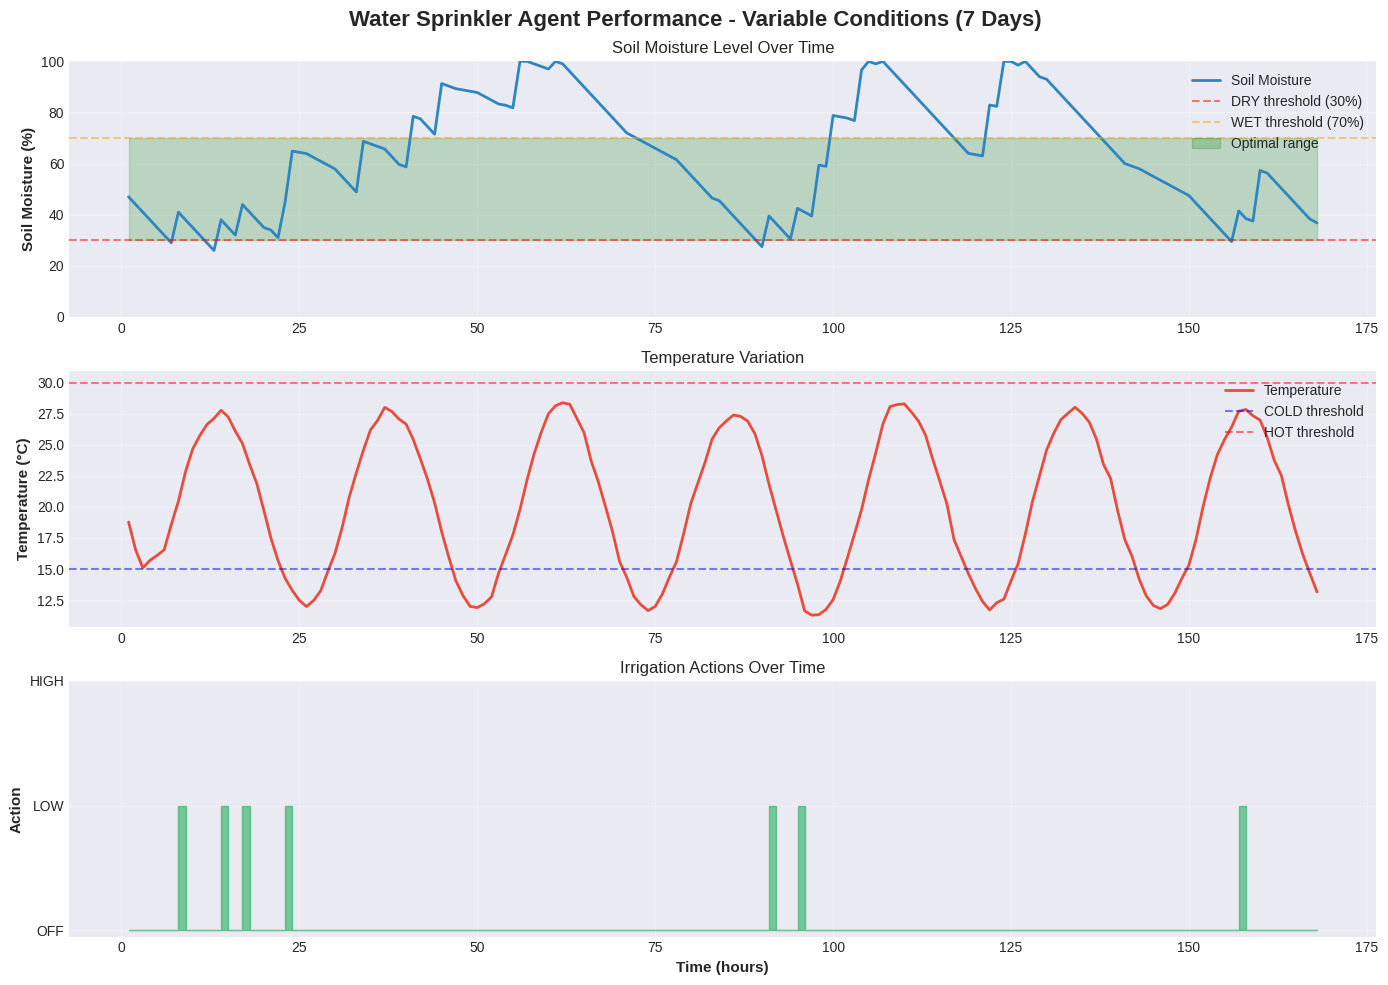

Visualization complete!


In [11]:
# Create visualization
fig, axes = plt.subplots(3, 1, figsize=(14, 10))
fig.suptitle('Water Sprinkler Agent Performance - Variable Conditions (7 Days)', fontsize=16, fontweight='bold')

# Convert history to DataFrame
df3 = pd.DataFrame(agent3.history)

# Plot 1: Moisture levels over time
ax1 = axes[0]
ax1.plot(df3['time'], df3['moisture'], linewidth=2, color='#2E86C1', label='Soil Moisture')
ax1.axhline(y=30, color='red', linestyle='--', alpha=0.5, label='DRY threshold (30%)')
ax1.axhline(y=70, color='orange', linestyle='--', alpha=0.5, label='WET threshold (70%)')
ax1.fill_between(df3['time'], 30, 70, alpha=0.2, color='green', label='Optimal range')
ax1.set_ylabel('Soil Moisture (%)', fontsize=11, fontweight='bold')
ax1.set_ylim(0, 100)
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)
ax1.set_title('Soil Moisture Level Over Time', fontsize=12)

# Plot 2: Temperature over time
ax2 = axes[1]
ax2.plot(df3['time'], df3['temperature'], linewidth=2, color='#E74C3C', label='Temperature')
ax2.axhline(y=15, color='blue', linestyle='--', alpha=0.5, label='COLD threshold')
ax2.axhline(y=30, color='red', linestyle='--', alpha=0.5, label='HOT threshold')
ax2.set_ylabel('Temperature (°C)', fontsize=11, fontweight='bold')
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3)
ax2.set_title('Temperature Variation', fontsize=12)

# Plot 3: Actions taken
ax3 = axes[2]
action_numeric = df3['action'].map({'OFF': 0, 'LOW': 1, 'HIGH': 2})
ax3.fill_between(df3['time'], 0, action_numeric, step='post', alpha=0.6, color='#27AE60')
ax3.set_ylabel('Action', fontsize=11, fontweight='bold')
ax3.set_yticks([0, 1, 2])
ax3.set_yticklabels(['OFF', 'LOW', 'HIGH'])
ax3.set_xlabel('Time (hours)', fontsize=11, fontweight='bold')
ax3.grid(True, alpha=0.3)
ax3.set_title('Irrigation Actions Over Time', fontsize=12)

plt.tight_layout()
plt.show()

print("Visualization complete!")

In [12]:
def calculate_metrics(agent_history: List[Dict]) -> Dict:
    """Calculate performance metrics from simulation history"""
    df = pd.DataFrame(agent_history)

    # Water usage (assuming LOW=1 unit, HIGH=2 units per hour)
    water_usage = (df['action'] == 'LOW').sum() * 1 + (df['action'] == 'HIGH').sum() * 2

    # Time in optimal moisture range (30-70%)
    optimal_time = ((df['moisture'] >= 30) & (df['moisture'] <= 70)).sum()
    optimal_percentage = (optimal_time / len(df)) * 100

    # Over-irrigation events (irrigating when moisture > 70%)
    over_irrigation = ((df['moisture'] > 70) & (df['action'] != 'OFF')).sum()

    # Under-irrigation events (moisture < 30% for extended period)
    under_irrigation = ((df['moisture'] < 30)).sum()

    # Action distribution
    action_dist = df['action'].value_counts()

    return {
        'total_water_usage': water_usage,
        'optimal_time_percentage': optimal_percentage,
        'over_irrigation_events': over_irrigation,
        'under_irrigation_hours': under_irrigation,
        'action_distribution': action_dist.to_dict(),
        'avg_moisture': df['moisture'].mean(),
        'moisture_std': df['moisture'].std()
    }

# Calculate metrics for scenario 3
metrics3 = calculate_metrics(agent3.history)

print("="*60)
print("PERFORMANCE METRICS - Variable Conditions (7 days)")
print("="*60)
print(f"Total Water Usage:          {metrics3['total_water_usage']:.0f} units")
print(f"Time in Optimal Range:      {metrics3['optimal_time_percentage']:.1f}%")
print(f"Over-irrigation Events:     {metrics3['over_irrigation_events']:.0f}")
print(f"Under-irrigation Hours:     {metrics3['under_irrigation_hours']:.0f}")
print(f"Average Moisture:           {metrics3['avg_moisture']:.1f}%")
print(f"Moisture Std Deviation:     {metrics3['moisture_std']:.1f}%")
print("\nAction Distribution:")
for action, count in metrics3['action_distribution'].items():
    print(f"  {action:5s}: {count:3d} times ({count/168*100:5.1f}%)")
print("="*60)

PERFORMANCE METRICS - Variable Conditions (7 days)
Total Water Usage:          7 units
Time in Optimal Range:      58.3%
Over-irrigation Events:     0
Under-irrigation Hours:     5
Average Moisture:           63.5%
Moisture Std Deviation:     22.0%

Action Distribution:
  OFF  : 161 times ( 95.8%)
  LOW  :   7 times (  4.2%)


In [13]:
class TimerBasedSystem:
    """Traditional timer-based irrigation (waters every 12 hours)"""

    def __init__(self, interval=12):
        self.interval = interval
        self.history = []

    def run_cycle(self, environment: Environment):
        """Fixed schedule irrigation"""
        if environment.time_step % self.interval == 0:
            action = Action.LOW  # Always use LOW pressure
        else:
            action = Action.OFF

        environment.update(action)
        self.history.append({
            'time': environment.time_step,
            'action': action.value,
            'moisture': environment.moisture,
            'temperature': environment.temperature
        })
        return action

# Run comparison simulation
print("Running comparison: Rational Agent vs Timer System\n")

# Agent simulation
env_agent = Environment(initial_moisture=50, initial_temp=22)
agent_comp = WaterSprinklerAgent()
random.seed(42)
for _ in range(168):
    agent_comp.run_cycle(env_agent)

# Timer simulation
env_timer = Environment(initial_moisture=50, initial_temp=22)
timer_system = TimerBasedSystem(interval=12)
random.seed(42)
for _ in range(168):
    timer_system.run_cycle(env_timer)

# Calculate metrics
metrics_agent = calculate_metrics(agent_comp.history)
metrics_timer = calculate_metrics(timer_system.history)

# Create comparison table
comparison_df = pd.DataFrame({
    'Metric': [
        'Water Usage (units)',
        'Optimal Time (%)',
        'Over-irrigation Events',
        'Under-irrigation Hours',
        'Avg Moisture (%)'
    ],
    'Timer System': [
        f"{metrics_timer['total_water_usage']:.0f}",
        f"{metrics_timer['optimal_time_percentage']:.1f}",
        f"{metrics_timer['over_irrigation_events']:.0f}",
        f"{metrics_timer['under_irrigation_hours']:.0f}",
        f"{metrics_timer['avg_moisture']:.1f}"
    ],
    'Rational Agent': [
        f"{metrics_agent['total_water_usage']:.0f}",
        f"{metrics_agent['optimal_time_percentage']:.1f}",
        f"{metrics_agent['over_irrigation_events']:.0f}",
        f"{metrics_agent['under_irrigation_hours']:.0f}",
        f"{metrics_agent['avg_moisture']:.1f}"
    ],
    'Improvement': [
        f"{((metrics_timer['total_water_usage'] - metrics_agent['total_water_usage']) / metrics_timer['total_water_usage'] * 100):.1f}%",
        f"+{(metrics_agent['optimal_time_percentage'] - metrics_timer['optimal_time_percentage']):.1f}%",
        f"-{(metrics_timer['over_irrigation_events'] - metrics_agent['over_irrigation_events']):.0f}",
        f"-{(metrics_timer['under_irrigation_hours'] - metrics_agent['under_irrigation_hours']):.0f}",
        f"+{(metrics_agent['avg_moisture'] - metrics_timer['avg_moisture']):.1f}%"
    ]
})

print("="*80)
print("PERFORMANCE COMPARISON - 7 Day Simulation")
print("="*80)
print(comparison_df.to_string(index=False))
print("="*80)

Running comparison: Rational Agent vs Timer System

PERFORMANCE COMPARISON - 7 Day Simulation
                Metric Timer System Rational Agent Improvement
   Water Usage (units)           14              1       92.9%
      Optimal Time (%)          1.2           24.4      +23.2%
Over-irrigation Events           13              0         -13
Under-irrigation Hours            0              0          -0
      Avg Moisture (%)         91.5           80.7     +-10.8%


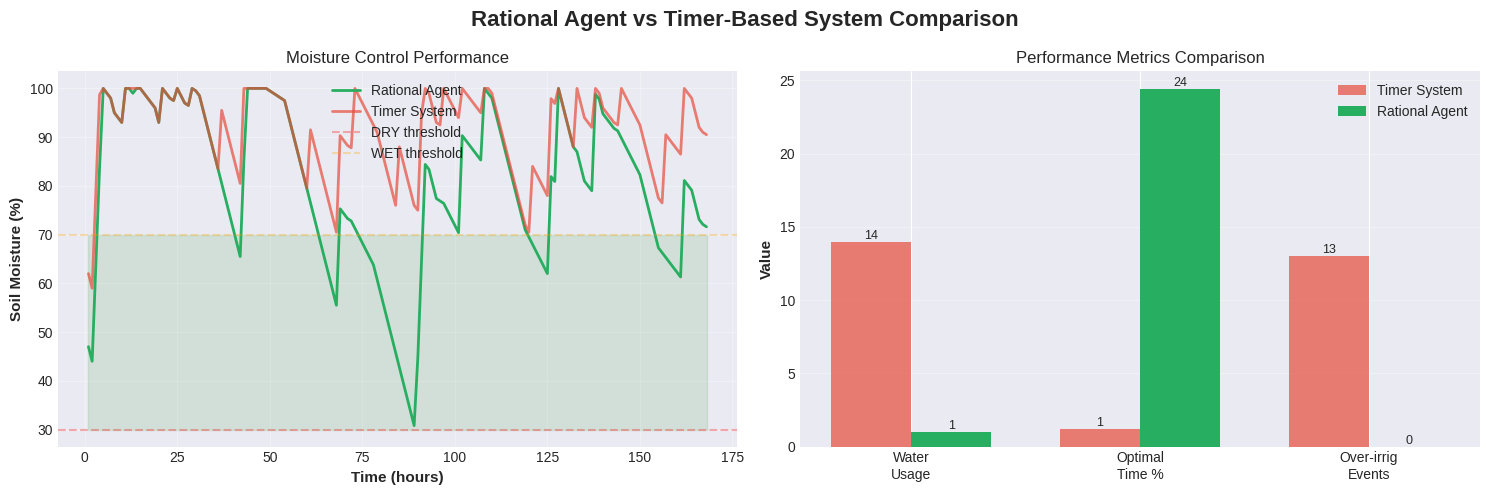

Comparison visualization complete!


In [14]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Rational Agent vs Timer-Based System Comparison', fontsize=16, fontweight='bold')

# Plot 1: Moisture levels comparison
ax1 = axes[0]
df_agent = pd.DataFrame(agent_comp.history)
df_timer = pd.DataFrame(timer_system.history)

ax1.plot(df_agent['time'], df_agent['moisture'], linewidth=2, label='Rational Agent', color='#27AE60')
ax1.plot(df_timer['time'], df_timer['moisture'], linewidth=2, label='Timer System', color='#E74C3C', alpha=0.7)
ax1.axhline(y=30, color='red', linestyle='--', alpha=0.3, label='DRY threshold')
ax1.axhline(y=70, color='orange', linestyle='--', alpha=0.3, label='WET threshold')
ax1.fill_between(df_agent['time'], 30, 70, alpha=0.1, color='green')
ax1.set_xlabel('Time (hours)', fontsize=11, fontweight='bold')
ax1.set_ylabel('Soil Moisture (%)', fontsize=11, fontweight='bold')
ax1.set_title('Moisture Control Performance', fontsize=12)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Metrics comparison bar chart
ax2 = axes[1]
metrics_names = ['Water\nUsage', 'Optimal\nTime %', 'Over-irrig\nEvents']
agent_values = [
    metrics_agent['total_water_usage'],
    metrics_agent['optimal_time_percentage'],
    metrics_agent['over_irrigation_events']
]
timer_values = [
    metrics_timer['total_water_usage'],
    metrics_timer['optimal_time_percentage'],
    metrics_timer['over_irrigation_events']
]

x = np.arange(len(metrics_names))
width = 0.35

bars1 = ax2.bar(x - width/2, timer_values, width, label='Timer System', color='#E74C3C', alpha=0.7)
bars2 = ax2.bar(x + width/2, agent_values, width, label='Rational Agent', color='#27AE60')

ax2.set_ylabel('Value', fontsize=11, fontweight='bold')
ax2.set_title('Performance Metrics Comparison', fontsize=12)
ax2.set_xticks(x)
ax2.set_xticklabels(metrics_names)
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.0f}',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print("Comparison visualization complete!")

STATE FREQUENCY ANALYSIS (7-day simulation)
State                           Frequency Percentage
------------------------------------------------------------
(MODERATE, MILD, SUNNY)                52      31.0%
(WET, MILD, SUNNY)                     33      19.6%
(MODERATE, COLD, SUNNY)                21      12.5%
(WET, MILD, CLOUDY)                    13       7.7%
(MODERATE, MILD, CLOUDY)                9       5.4%
(WET, MILD, RAINY)                      8       4.8%
(DRY, MILD, SUNNY)                      6       3.6%
(WET, COLD, CLOUDY)                     6       3.6%
(WET, COLD, SUNNY)                      5       3.0%
(MODERATE, COLD, CLOUDY)                5       3.0%


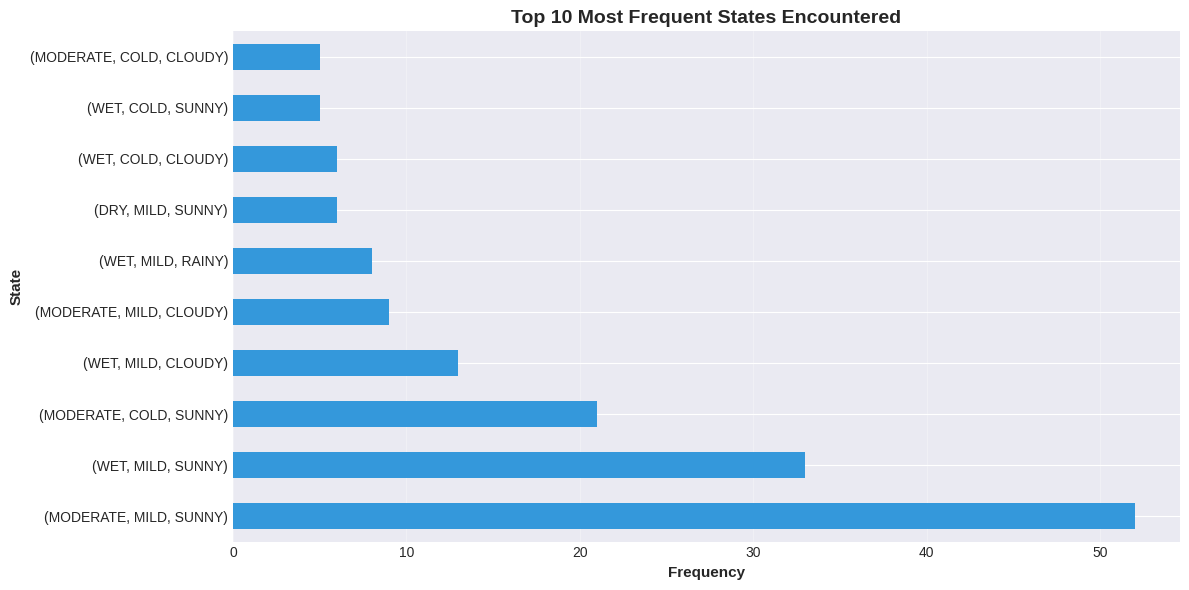

In [15]:
# Analyze state frequencies
df_agent = pd.DataFrame(agent3.history)
state_freq = df_agent['state'].value_counts()

print("="*60)
print("STATE FREQUENCY ANALYSIS (7-day simulation)")
print("="*60)
print(f"{'State':<30} {'Frequency':>10} {'Percentage':>10}")
print("-"*60)
for state, freq in state_freq.head(10).items():
    percentage = (freq / len(df_agent)) * 100
    print(f"{state:<30} {freq:>10} {percentage:>9.1f}%")
print("="*60)

# Visualize state distribution
fig, ax = plt.subplots(figsize=(12, 6))
state_freq.head(10).plot(kind='barh', ax=ax, color='#3498DB')
ax.set_xlabel('Frequency', fontsize=11, fontweight='bold')
ax.set_ylabel('State', fontsize=11, fontweight='bold')
ax.set_title('Top 10 Most Frequent States Encountered', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

ACTION EFFECTIVENESS ANALYSIS
Action    Avg Moisture Change      Std Dev      Count
----------------------------------------------------------------------
LOW                   +12.29%        0.76%          7
OFF                    -0.60%        5.61%        160


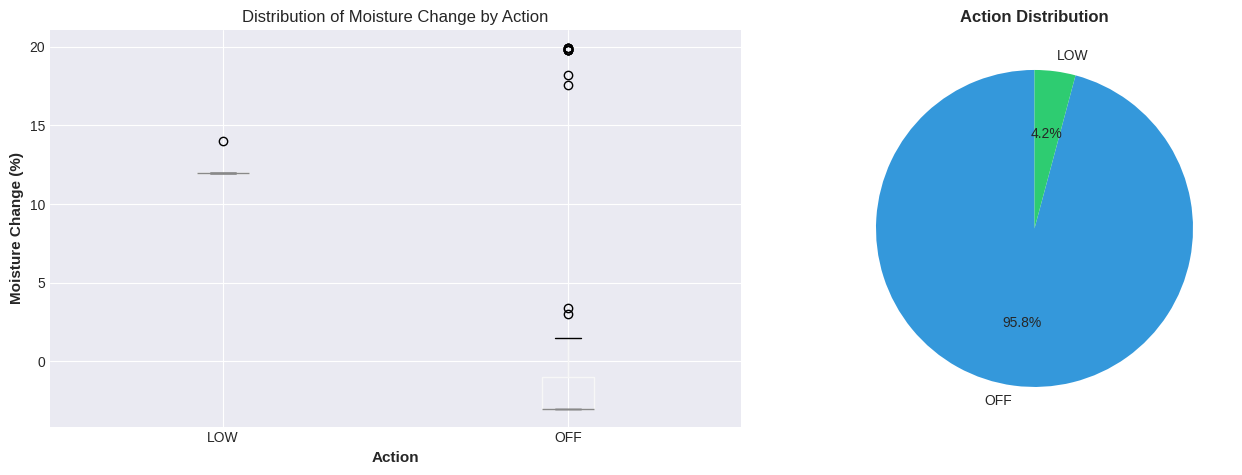

In [16]:
# Analyze moisture change after actions
df_agent = pd.DataFrame(agent3.history)
df_agent['moisture_change'] = df_agent['moisture'].diff()

action_effectiveness = df_agent.groupby('action')['moisture_change'].agg(['mean', 'std', 'count'])

print("="*70)
print("ACTION EFFECTIVENESS ANALYSIS")
print("="*70)
print(f"{'Action':<8} {'Avg Moisture Change':>20} {'Std Dev':>12} {'Count':>10}")
print("-"*70)
for action in action_effectiveness.index:
    mean_change = action_effectiveness.loc[action, 'mean']
    std_change = action_effectiveness.loc[action, 'std']
    count = action_effectiveness.loc[action, 'count']
    print(f"{action:<8} {mean_change:>+19.2f}% {std_change:>11.2f}% {count:>10.0f}")
print("="*70)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Box plot of moisture changes by action
ax1 = axes[0]
df_agent.boxplot(column='moisture_change', by='action', ax=ax1)
ax1.set_xlabel('Action', fontsize=11, fontweight='bold')
ax1.set_ylabel('Moisture Change (%)', fontsize=11, fontweight='bold')
ax1.set_title('Distribution of Moisture Change by Action', fontsize=12)
plt.sca(ax1)
plt.xticks(rotation=0)
ax1.get_figure().suptitle('')  # Remove default title

# Action frequency pie chart
ax2 = axes[1]
action_counts = df_agent['action'].value_counts()
colors = ['#3498DB', '#2ECC71', '#E74C3C']
ax2.pie(action_counts.values, labels=action_counts.index, autopct='%1.1f%%',
        colors=colors, startangle=90)
ax2.set_title('Action Distribution', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

In [17]:
# Calculate comprehensive savings
water_saved = metrics_timer['total_water_usage'] - metrics_agent['total_water_usage']
water_efficiency = (water_saved / metrics_timer['total_water_usage']) * 100

optimal_improvement = metrics_agent['optimal_time_percentage'] - metrics_timer['optimal_time_percentage']

print("\n" + "="*70)
print("WATER CONSERVATION & EFFICIENCY SUMMARY")
print("="*70)
print(f"\n📊 WATER USAGE:")
print(f"   Traditional Timer System:    {metrics_timer['total_water_usage']:>6.0f} units")
print(f"   Rational Agent:              {metrics_agent['total_water_usage']:>6.0f} units")
print(f"   Water Saved:                 {water_saved:>6.0f} units")
print(f"   Efficiency Improvement:      {water_efficiency:>6.1f}%")

print(f"\n🌱 PLANT HEALTH:")
print(f"   Timer - Optimal Range Time:  {metrics_timer['optimal_time_percentage']:>6.1f}%")
print(f"   Agent - Optimal Range Time:  {metrics_agent['optimal_time_percentage']:>6.1f}%")
print(f"   Improvement:                 +{optimal_improvement:>5.1f}%")

print(f"\n⚠️  PROBLEM PREVENTION:")
print(f"   Timer - Over-irrigation:     {metrics_timer['over_irrigation_events']:>6.0f} events")
print(f"   Agent - Over-irrigation:     {metrics_agent['over_irrigation_events']:>6.0f} events")
print(f"   Reduction:                   {metrics_timer['over_irrigation_events'] - metrics_agent['over_irrigation_events']:>6.0f} events")

print(f"\n💰 ESTIMATED COST SAVINGS (assuming $0.50 per unit):")
cost_per_unit = 0.50
annual_savings = (water_saved / 7) * 365 * cost_per_unit  # Extrapolate to year
print(f"   Daily savings:               ${(water_saved / 7) * cost_per_unit:>6.2f}")
print(f"   Weekly savings:              ${water_saved * cost_per_unit:>6.2f}")
print(f"   Annual savings (estimated):  ${annual_savings:>6.2f}")

print("\n" + "="*70)
print("✅ CONCLUSION: Rational agent achieves superior water conservation")
print("   while maintaining better soil moisture control!")
print("="*70)


WATER CONSERVATION & EFFICIENCY SUMMARY

📊 WATER USAGE:
   Traditional Timer System:        14 units
   Rational Agent:                   1 units
   Water Saved:                     13 units
   Efficiency Improvement:        92.9%

🌱 PLANT HEALTH:
   Timer - Optimal Range Time:     1.2%
   Agent - Optimal Range Time:    24.4%
   Improvement:                 + 23.2%

⚠️  PROBLEM PREVENTION:
   Timer - Over-irrigation:         13 events
   Agent - Over-irrigation:          0 events
   Reduction:                       13 events

💰 ESTIMATED COST SAVINGS (assuming $0.50 per unit):
   Daily savings:               $  0.93
   Weekly savings:              $  6.50
   Annual savings (estimated):  $338.93

✅ CONCLUSION: Rational agent achieves superior water conservation
   while maintaining better soil moisture control!


In [18]:
# Export policy table
policy_df = agent.get_policy_summary()
policy_df.to_csv('policy_table.csv', index=False)
print("✅ Policy table exported to: policy_table.csv")

# Export simulation results
results_df = pd.DataFrame(agent3.history)
results_df.to_csv('simulation_results.csv', index=False)
print("✅ Simulation results exported to: simulation_results.csv")

# Export comparison metrics
comparison_df.to_csv('performance_comparison.csv', index=False)
print("✅ Performance comparison exported to: performance_comparison.csv")

print("\n📁 All results exported successfully!")

✅ Policy table exported to: policy_table.csv
✅ Simulation results exported to: simulation_results.csv
✅ Performance comparison exported to: performance_comparison.csv

📁 All results exported successfully!


In this chapter, we'll cover Jupyter Notebooks, including how to write and execute code and how to write text in the **Markdown** format. We'll also discuss what the kernel is, so that you understand generally how Jupyter Notebooks work.

<div class="alert alert-success">
Jupyter notebooks are a way to combine executable code, code outputs, and text into one connected file.
</div>

<div class="alert alert-info">
The official documentation from project Jupyter is available
<a href="https://jupyter-notebook.readthedocs.io/en/stable/" class="alert-link">here</a>
and they also have some example notebooks
<a href="https://github.com/jupyter/notebook/tree/master/docs/source/examples/Notebook" class="alert-link">here</a>
.
</div>

## Menu Options & Shortcuts

To get a quick tour of the Jupyter user-interface, click on the 'Help' menu, then click 'User Interface Tour'.

There are also a large number of useful keyboard shortcuts. Click on the 'Help' menu, and then 'Keyboard Shortcuts' to see a list.

## Cells

<div class="alert alert-success">
    The main organizational structure of the notebook are <b> cells </b>.
</div>

**Cells** are an independent 'unit'. When you click into a cell, you can 'run' it by clicking Shift + Enter, or by pressing the play (Run) button at the top of your notebook.

Cells come in different types for writing different things - mainly, text or code.

### Markdown Cells

Cells, can be plain text. In this book, for chapters where code is included, any place you see text - meaning places were we aren'twriting and executing code  - will be written in **Markdown**.

Markdown is a way to specify all the text formatting you see within the text itself.

#### _Italics_ & __Bold__

For example, *italicized text* can be specified with an \_underscore\_ or \*single asterisks\*. So, using markdown formatting, that text would appear as follows:

For example, italicized text can be specified with an _underscore_ or *single asterisks*.

**Bold text** requires \_\_two underccores\_\_ or \*\*two asterisks\*\* surrounding the text you would like to bold. Using Markdown formatting, that text would look like this:

**Bold text** requires __two underccores__ or **two asterisks** surrounding the text you would like to bold.



#### Headers

There are a number of different size header you can use with Markdown formatting. The number of pound signs preceeding the header specifies the size of the header.

For example, the following:

```
# Headers are specified with a pound sign
## The more pound signs, the smaller the header
#### But it's still larger
than just plain text.
```

would appear as follows using Markdown formatting:


## Headers are specified with a pound sign

### The more pound signs, the smaller the header

#### But it's still larger

than just plain text.

---

Note that to specify text for a header. the pound sign is followed by a space before the text for the header. The largest header -- specified by 1 pound sign -- is referred to as an H1 header. The second largest, H2, and so on and so forth.

#### Lists

Finally, **lists** are also possible with Markdown formatting. Ordered lists are specified with a number, followed by a decimal point, followed by a space and then the text for the list. For example, the following:

```
1. numbered item
2. item 2
3. item 3
```

would appear as follows with Markdown formatting:

1. numbered item
2. item 2
3. item 3

Bulleted or unordered lists are also possible. these are specified by either a dash (`-`) or an asterisk (`*`) instead of the number and decimal point.

For example, either of the following:

```
- item 1
- item 2
- item 3
```

or

```
* item 1
* item 2
* item 3
```

would appear as follows with Markdown formatting:

- item 1
- item 2
- item 3

### Code Cells

Markdown is really helpful when you want to share text within a Jupyter notebook; however, you're here to learn to program. So let's start talking about code! Whenever you're writing code, you'll want to be sure the cell is set to be a code cell. Within a Jupyter notebook, whenever a cell is selected, you can look at the menu across the top. The drop-down menu will specify what type of cell you're working with.

Here, we see an example of what you would see for a Markdown cell.

![Markdown cell specified along toolbar](https://github.com/shanellis/pythonbook/blob/master/content/images/01-intro/markdown_cell.png?raw=1)

To change this cell to a code cell, you would select "Code" from the drop-down menu. You'd then be able to write and execute code from the cell!

![Code selected from drop-down menu](https://github.com/shanellis/pythonbook/blob/master/content/images/01-intro/code_cell.png?raw=1)

The next cell is an example of a code cell. The first line in that cell is a **comment**. Comments are ignored by the computer and are there to help humans reading the code understand what's going on. Comments always start with a pound sign. Note that a pound sign in a Markdown cell indicates something different (a header) than it does in a code cell (a comment).

The second and third line in the example below are lines of Python code! Here we're assigning information to two variables: `a` and `b`. We'll talk all about variable assignment in the next chapter.

In [ ]:
# Cell can also be code.
a = 1
b = 2

#### Running Code

What's important to know now is that Jupyter notebooks don't *just* allow you to write code. You can also **execute the code**. Nothing happens until you execute (or "run") code.

For example, in the first cell above, that code was typed but never executed. We know that it wasn't executed because to the left of the cell we see `In [ ]:`.

![Code cell not yet executed](https://github.com/shanellis/pythonbook/blob/master/content/images/01-intro/not_executed.png?raw=1)

The empty brackets suggested that this code has not yet been executed.

Once executed, a number will show up within those brackets:

![Code cell not yet executed](https://github.com/shanellis/pythonbook/blob/master/content/images/01-intro/executed_code.png?raw=1)

The first code cell you run in a Jupyter notebook will have a `[1]`. The second a `[2]` and so on and so forth.

To execute a cell, you can click on the cell you'd like to run and click "Run" along the toolbar at the top. Or, more likely, you'll want to get in the habit of using hte keyboard shortcut `Shift + Enter` to run your cells. note that `Shift + Enter` will run code cells *and* format Markdown cells.

One important caveat is that if you ever see a `[*]`. to to the left of your code cell, this indicates that the cell is still running. This cann happen if you write code that takes a while to run *or* if you've written code that will run forever (such as an infinite loop).

If this happens and you do *not* want to allow the code to continue to execute (for example, you have an infinite loop and want the code to stop from running, you can click on the square stop icon from the toolbar at the top.

![Stop code cell from executing](https://github.com/shanellis/pythonbook/blob/master/content/images/01-intro/stop.png?raw=1)

Upon executing the code in a cell, often, there will be some sort of output. The code below says subtract 2 (the value stored in `b`) from 1 (the value stored in `a`) and store that in the variable `c`. Then, the final line here says, print that value out to the screen.

In [ ]:
# Cells can also have output, that gets printed out below the cell.
c = a - b
print(c)

-1


What you see above is why notebooks are so great! They allow explanatory text, python code, *and* the outputs from that code to intermingle in a single document!

Before we move on, one more piece of information about Jupyter notebooks in particular. If the last line of code in a code cell is a variable name, the Jupyter notebook, will print the contents of that varaible to your screen, without you having to put `print()` around it. We'll use this a bunch throughout the book, so it's worth noting now, even though we haven't *exactly* covered what variables are...yet!

In [ ]:
# if variable last thing in cell
# output will be variable conents
c

-1

#### Cell Order

Ok, so we've discussed that the numbers in the square brackets to the left of a cell show which cells have been run, and in what order and that an asterisk (`*`) means that the cell is currently running. What we haven't yet discussed is that the order in which the cells are run does ***not*** matter to Python or Jupyter notebooks.

This allows you to flexibly test and develop code. For example, say you've run a few cells of code in order from top to bottom. Then, you realize you wanted a different value in that first code cell. You can go back to that first cell, change it to be the value you want, and then return back to a different cell. Python and Jupyter Notebooks will keep track of whatever was run most recently.

For beginners and individuals less familiar with working in notebooks, this can sometimes take a bit to get used to, but the benefits of this flexibility outweigh the cognitive load it takes to remember that the order isn't set in stone to go from top to bottom.

## Accessing Documentation

When you're new to Python (or any programming language), knowing where to look for more information is critical. While Google and StackOverflow will likely be very helpful, Python and Jupyter Notebooks have built-in ways for you to access documentation that will provide you with helpful information.

<div class="alert alert-success">
Jupyter has useful shortcuts. Add a single '?' after a function or class get a window with the documentation, or a double '??' to pull up the source code.
</div>

In [ ]:
# For example, execute this cell to see the documentation for the 'abs'
abs?

## Autocomplete

<div class="alert alert-success">
Jupyter also has
<a href="https://en.wikipedia.org/wiki/Command-line_completion" class="alert-link">tab complete</a>
capacities, which can autocomplete what you are typing, and/or be used to explore what code is available.  
</div>

In [ ]:
# Move your cursor to the end of the line, press tab, and a drop menu will appear showing all possible completions
ra

In [ ]:
# If there is only one option, tab-complete will auto-complete what you are typing
ran

## Web Browser

<div class="alert alert-success">
Jupyter notebooks display in a web browser. They are not hosted on the web, everything is happening locally.
</div>

If you click on the url in the browser, you will notice it says 'localhost'. This means it is connected to something locally, on your computer.

That local connection is to the 'kernel'.

## Kernels

<div class="alert alert-success">
The 'kernel' is the thing that executes your code. It is what connects the notebook (as you see it) with the part of your computer that runs code.
</div>

Your kernel also stores your **namespace** - all the variables and code that you have declared (executed).

It can be useful to clear and re-launch the kernel. You can do this from the 'kernel' drop down menu, at the top, optionally also clearing all ouputs. Note that this will erase any variables that are stored in memory.

<div class="alert alert-info">
For more useful information, check out Jupyter Notebooks
<a href="https://www.dataquest.io/blog/jupyter-notebook-tips-tricks-shortcuts/" class="alert-link">tips & tricks</a>
, and more information on how
<a href="http://jupyter.readthedocs.io/en/latest/architecture/how_jupyter_ipython_work.html" class="alert-link">notebooks work</a>.
</div>

## Exercises

Q1. **What does three underscores around text accomplish?**  

A) bold  
B) italicize  
C) bold + italicize  
D) plain text    


Q2. **Add a cell to a notebook, change it to be a Markdown cell, and add your name as (1) plain text, (2) italicized text, and (3) bold text.**
  

Q3. **What would happen if I specified a numbered list but put the same number before each list item?**  

A) the list would have the same number before each item  
B) markdown would still format it with sequential numbers  
C) markdown wouldn't know it was a list  
D) normal text with everything on a single line  


Q4. **Write code in a code cell and execute it so that the value returned from the cell is '6'.**


Q5. **If the following were in a code cell, what would be the output of the following?**

```python
a = 1
b = 2
c = 3
print(a + b + c)
```
  
Q6. **If the following were in a code cell, what would be the output of the following?**

```python
a = 1
b = 2
c = 3
a + b + c
```
  
Q7. **If the following were in a code cell, what would be the output of the following?**

```python
a = 1
b = 2
c = 3
```